# notebook: Habitat Functionality

## TOC:
    1. libraries
    2. Definition of the grid-class
    3. Definition of the landmarks-class
    4. Read a hdf5-file
    5. Prepare data
    6. Plot results

## 1. Libraries & Settings

In [57]:
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import sparse
from bisect import bisect_left
import random
from math import sqrt
from scipy.sparse.csgraph import dijkstra
import h5py

%matplotlib inline

## 2. Definition of the grid-class

We manage landscapes as grids: columns of the grid are parallels to the y-axis (North-South) of the landscape, and rows to the x-axis (East-West). The rows and columns are numbered from the top left corner, and the order of nodes (note: the terms nodes and pixels will be used interchangeably) in the graph correspond to the English reading direction (i.e. from left to right and from top to bottom). These specifications are just as in the ESRI ASCII file for grids. Thus, if there are n columns, the pixel on the i-th row and j-th column correspond to the node i\*n+j. All numbering start with 0. **COMMENT: Are we sure of this? I would think that I have provided data assuming 1 as its start**

A node can be identified in different ways: its number or node id, its physical coordinates, and its grid coordinates. The pixel's number has been described above (i.e. from top-left corner to bottom-right corner), the physical coordinates are the values on the y- and x-axis, the grid coordinates are the row and column id.   

An object of the class **Grid** has the following instance variables associated to it:
* A : affinity matrix in the csr format. Great for matrix-vector multiplications
* A_dok : affinity matrix in the dok format. Access to edge weight in O(1)
* map_size : tuple (size along the y axis, size along the x axis). This is the physical size (in meters or kilometers) of the landscape.
* shape : tuple (number of rows, number of columns). This is the size of the grid representing the landscape
* pixel_size : tuple (pixel size along the y axis, pixel size along the x axis)
* x_ticks : list delimitating the pixels along the x axis (in the physical coordinates). The ith column is delimitated by x_ticks[i] and x_ticks[i+1], if there are n colums, len(x_ticks) will be n+1.
* y_ticks : list delimitating the pixels along the y axis (in the physical coordinates). The ith row is delimitated by y_ticks[i] and y_ticks[i+1], if there are n rows, len(y_ticks) will be n+1.

A set of **functions** allows to do plots and to do conversions between the different coordinates of nodes (i.e. id in the graph, physical coordinates, grid coordinates):
* ```set_affinities```: set the affinity values in a grid object.

Conversion functions:
* ```node_id_to_grid_coordinates```: get the grid coordinates (row id, column id) of a pixel
* ```node_id_to_coordinates```: get the physical (value along the y axis, value along the x axis) coordinates of a node
* ```coordinates_to_grid_coordinates```: from physical to grid coordinates
* ```coordinates_to_node_id```
* ```grid_coordinates_to_node_id```
* ```grid_coordinates_to_coordinates```

Checking functions:
* ```check_grid_coordinates```: check if grid coordinates are valid. Raises IndexError if not
* ```check_coordinates```: check if physical coordinates are valid. Raises IndexError if not
* ```check_node_id```: check if node id is valid. Raises IndexError if not

Plotting functions:
* ```plot_indegrees```: plot the in-degree of the nodes of a grid (specific version of ```plot```)
* ```plot_outdegrees```: plot the out-degree of the nodes of a grid (specific version of ```plot```)
* ```plot```: plot values from a grid

In [58]:
class Grid:
	def __init__(self, map_size, shape, graph=None, qualities=None):
		'''
		Inputs: 
			- graph : sparse matrix (if None, the graph can be set later using set_affinities)
			- map_size : tuple (size along the y axis, size along the x axis). This is the physical size (in meters or kilometers) of the landscape.
			- shape : tuple (number of rows, number of columns). This is the size of the grid representing the landscape
		'''
		self.pixel_size = (map_size[0]/shape[0], map_size[1]/shape[1])
		self.shape = shape
		self.map_size = map_size
		self.n_rows, self.n_cols = shape
		self.N = shape[0] * shape[1]
		self.x_ticks = np.linspace(0, map_size[1], num=(shape[1]+1))
		self.y_ticks = np.linspace(0, map_size[0], num=(shape[0]+1))
		
		if graph is not None:
			self.set_affinities(graph)

		if qualities is not None:
			self.qualities = qualities
		else:
			self.qualities = np.ones(self.N)


	def set_affinities(self, graph):
		'''
		Set the affinity matrix A and A_dok.
		graph should be a sparse matrix.
		'''
		if graph.shape[0] != self.N:
			raise ValueError('The shape of the grid does not match the number of nodes of the graph')
		self.A = graph.tocsr()
		self.A_dok = graph.todok()
	
	def node_id_to_grid_coordinates(self, node_id):
		'''
		Return the grid coordinates (row id, column id) corresponding to a given node
		'''
		self.check_node_id(node_id)
		j = int(node_id % self.n_cols)
		i = (node_id - j) / self.n_cols
		return (i, j)


	def node_id_to_coordinates(self, node_id):
		'''
		Return the physical coordinates of a node (center of the corresponding pixel)
		'''
		return self.grid_coordinates_to_coordinates(self.node_id_to_grid_coordinates(node_id))
	
	def coordinates_to_grid_coordinates(self, coo):
		'''
		Return the grid coordinates (row id, column id) of the pixel containing the 
		physical coordinates "coo" (value along the y axis, value along the x axis)
		'''
		self.check_coordinates(coo)
	
		i = max(0, bisect_left(self.y_ticks, coo[0]) - 1)
		j = max(0, bisect_left(self.x_ticks, coo[1]) - 1)
		return (i,j)

	def coordinates_to_node_id(self, coo):
		'''
		Return the id of the node containing the physical coordinates "coo"
		the coordinates are interpreted as (value along the y axis, value along the x axis)
		'''
		return self.grid_coordinates_to_node_id(self.coordinates_to_grid_coordinates(coo))

	def grid_coordinates_to_node_id(self, grid_coo):
		'''
		Return the id of the node corresponding to the grid coordinates "grid_coo" (row id, column id)
		'''
		self.check_grid_coordinates(grid_coo)
		return grid_coo[0] * self.n_cols + grid_coo[1]

	def grid_coordinates_to_coordinates(self, grid_coo):
		'''
		Return the physical coordinates of the center of the pixel identified by "grid_coo" (row id, column id)
		'''
		self.check_grid_coordinates(grid_coo)
		return ((self.y_ticks[grid_coo[0]] + self.y_ticks[grid_coo[0] + 1])/2, (self.x_ticks[grid_coo[1]] + self.x_ticks[grid_coo[1] + 1])/2)
	
	def check_grid_coordinates(self, grid_coo):
		'''
		Check if grid coordinates are valid. Raises IndexError if not
		'''
		if grid_coo[0] >= self.n_rows or grid_coo[0] < 0:
			raise IndexError('row id outside the range')
		if grid_coo[1] >= self.n_cols or grid_coo[1] < 0:
			raise IndexError('column id outside the range')

	def check_coordinates(self, coo):
		'''
		Check if physical coordinates are valid. Raises IndexError if not
		'''
		if coo[0] > self.map_size[0] or coo[0] < 0:
			raise IndexError('y coordinate outside the range')
		if coo[1] > self.map_size[1] or coo[1] < 0:
			raise IndexError('x coordinate outside the range')

	def check_node_id(self, node_id):
		'''
		Check if node id is valid. Raises IndexError if not
		'''
		if node_id >= self.N or node_id < 0:
			raise IndexError('Node id outside the range')

	def plot_indegrees(self):
		indegrees = self.A.transpose().dot(np.ones((self.N, )))
		self.plot(indegrees)

	def plot_outdegrees(self):
		outdegrees = self.A.dot(np.ones((self.N, )))
		self.plot(outdegrees)

	def plot(self, values, source=None):
		if len(values) != self.N:
			raise ValueError('Needs a value for each pixel')
		
		z = np.reshape(values, self.shape)
		
		plt.figure()
		plt.imshow(z, cmap='RdYlGn', interpolation='nearest')
		plt.colorbar()
		if source is not None:
			plt.sc
		plt.show()

## 3. Definition of the landmarks-class

Our general approach is build on so called landmarks. This means that we won't compute the 'distance' (something equivalent to a distance or a similarity) between all pairs of nodes, but only between the nodes and the landmarks. This choice was made to allow for faster computation. Note that for the centrality computation as *n* landmarks approaches *n* nodes, this approximation converges to the real centrality.

We define a class **Landmarks**, which can be either distributed uniformly over the landscape or according to landscape quality. 

The following **functions** create and manipulate ```Landmarks```:
* ```set_n_landmarks```: creates either a proportion (if <1) or a number of landmarks (if >=1)
* ```choose_landmarks```: select landmarks uniformly distributed on the grid
* ```choose_landmarks_from_qualities```: takes a random sample of the highest quality nodes (**COMMENT: weighted by quality?**)

Functions for plotting:
* ```plot_landmarks```: plot the location of the landmarks
* ```plot_landmark```: plot the landmarks, and highlight the focal landmark?

Functions related to functionality:
* ```plot_landmark_similarities```
* ```similarities_from```
* ```similarities_to```
* ```habitat_functionalities```: Compute habitat functionalities of all the pixels as sums of similarities from an origin pixel to all destination pixels, weighted by the destinations' quality values.
* ```harmonic_approximation```

In [59]:
class Landmarks:
	
	def __init__(self, grid, n_landmarks=0.01, verbose=True, criterion='uniform'):
		'''
		 - grid is a Grid object representing the landscape

		 - n_landmarks is the number of landmark. If it is bigger than 1, it is rounded to the nearest integer, 
		   if it is in (0, 1), it is interpreted as the fraction of nodes to use as landmarks
		'''
		self.verbose = verbose
		self.G = grid
		self.set_n_landmarks(n_landmarks)
		if criterion=='qualities':
			self.choose_landmarks_from_qualities()
		elif criterion=='uniform':
			self.choose_landmarks()
		else:
			print ("Invalid criterion, choosing landmarks uniformly.")
			self.choose_landmarks()


	def set_n_landmarks(self, n_landmarks):
		'''
		Set self.n_landmarks, the number of landmarks to use, based on the parameter n_landmarks

			If n_landmark it is bigger than 1, it is rounded to the nearest integer, 
			if it is in (0, 1), it is interpreted as the fraction of nodes to use as landmarks
		'''
		N = self.G.N
		if (n_landmarks <= 0 or n_landmarks > N):
			raise ValueError('n_landmarks must be in the interval (0, number of nodes]')
		elif n_landmarks >= 1:
			self.n_landmarks = int(round(n_landmarks))
		else:
			self.n_landmarks = int(round(N * n_landmarks))

	def choose_landmarks(self):
		'''
		Select landmarks uniformly distributed on the grid
		'''

		n_rows, n_cols = self.G.shape
		N = self.G.N

		l_cols = int(max(1, min(self.n_landmarks, round(sqrt(n_cols*self.n_landmarks/n_rows)))))
		
		l_full_rows = int(self.n_landmarks//l_cols)
		n_extra = int(self.n_landmarks - l_cols*l_full_rows)
		
		l_rows = l_full_rows
		if n_extra > 0:
			l_rows += 1
			print('Warning: Landmarks are not uniformly spread. Consider using {} or {} landmarks instead of {}'.format(self.n_landmarks - n_extra, self.n_landmarks - n_extra + l_cols, self.n_landmarks))
		
		rows_indices = [int((2*i+1) * n_rows / l_rows / 2) for i in range(l_rows)]
		col_indices = [int((2*i+1) * n_cols / l_cols / 2) for i in range(l_cols)]
		extra_indices = [int((2*i+1) * n_cols / n_extra / 2) for i in range(n_extra)]
		
		self.landmarks = np.zeros((self.n_landmarks,), dtype=np.int32)
		i = 0
		for r in rows_indices[:l_full_rows]:
			for c in col_indices:
				self.landmarks[i] = self.G.grid_coordinates_to_node_id((r,c))
				i += 1
		for c in extra_indices:
			self.landmarks[i] = self.G.grid_coordinates_to_node_id((rows_indices[-1],c))
			i += 1
	
	def choose_landmarks_from_qualities(self):
		 highest_quality_nodes = np.argsort(self.G.qualities)[-self.n_landmarks*100:-1][::-1]
		 self.landmarks = random.sample(highest_quality_nodes, self.n_landmarks)

	def plot_landmarks(self):

		values = np.zeros((self.G.N,))
		values[self.landmarks] = 1
		self.G.plot(values)

	def plot_landmark(self, landmark_id):

		values = np.zeros((self.G.N,))
		print(landmark_id)
		print(self.landmarks[landmark_id])
		values[self.landmarks[landmark_id]] = 1
		self.G.plot(values)

	def plot_landmark_similarities(self, landmark_id):
		
		affinities = self.similarities_L2all[landmark_id, :]
		self.G.plot(affinities)

	def similarities_to_landmarks(self, min_affinity=0, affinity_to_cost=None, distance_transformation=None, distance_to_similarity=None):
		'''
		Compute the affinities from landmarks to all nodes, and from all nodes to landmarks
		Store it in self.L2all (horizontal: n_landmarks x n_nodes) and self.all2L (vertical: n_nodes x n_landmarks)
		
		N.B. : To avoid confusion, cost and affinities are properties of edges, while distances and similarities are properties of pair of nodes that are not necessarily directly connected.
		
		Parameters
		----------
			min_affinity: float (default = 1e-3)
			Affinities below this value will not be considered as possible steps.
			They will be associated with an infinite cost, will have an infinite distance to all landmark, 
			and a 0 similarity to all node.

			affinity_to_cost: function handle (default = None)
			Function that defines the transformation of affinities into costs. 
			It must accept a numpy vector of floats (the affinities) and return a vector of the same size (the costs)
			if None, cost are defined as 1 / affinities.

			distance_transformation: function handle (default = None)
			Function that would be applied to the results the dijkstra distances computation.
			self.distances_L2all = distance_transformation(dijkstra_results).
			If distance_transformation is None, self.distances_L2all = dijkstra_results.
			The same goes for self.distances_all2L.
			distance_transformation=np.log can be a good choice

			distance_to_similarity: function handle (default = None)
			Function that defines the transformation of distances into similarities.
			if None, similarities are defined as (max_distance - distance) / max_distance.

		'''

		def finite_max(a):
			''' Returns the maximum of an array, excluding infinte values
			'''
			return np.amax(a[np.isfinite(a)])
		
		
		A = self.G.A.copy() # make a copy of the affinity matrix

		# Transformation of affinities to cost
		impossible_steps = A.data < min_affinity
		if affinity_to_cost == None: 	# default affinity to cost transformation
			A.data[:] = 1. / A.data
		else: 							# user specified affinity to cost transformation
			A.data[:] = affinity_to_cost(A.data)
		A.data[impossible_steps] = np.inf

		
		# From landmarks to all points
		##############################
		if self.verbose:
			print("Compute similarities from landmarks to all nodes...")

		# Shortest-path computation with Dijkstra
		self.distances_L2all = dijkstra(A, indices=self.landmarks)

		# Optional distance transformation
		if distance_transformation != None: 
			self.distances_L2all = distance_transformation(self.distances_L2all)

		# Distance to similarity transformation
		if distance_to_similarity == None: 	# default distance to similarity transformation
			self.similarities_L2all = (finite_max(self.distances_L2all) - self.distances_L2all)/finite_max(self.distances_L2all)
			self.similarities_L2all[self.distances_L2all == np.inf] = 0
		else:								# user specified distance to similarity transformation
			self.similarities_L2all = distance_to_similarity(self.distances_L2all)

		# From all points to landmarks
		##############################
		if self.verbose:
			print("Compute similarities from all nodes to landmarks...")

		# Shortest-path computation with Dijkstra
		self.distances_all2L = np.transpose(dijkstra(A.transpose(), indices=self.landmarks))

		# Optional distance transformation
		if distance_transformation != None: 
			self.distances_all2L = distance_transformation(self.distances_all2L)

		# Distance to similarity transformation
		if distance_to_similarity == None: 	# default distance to similarity transformation
			self.similarities_all2L = (finite_max(self.distances_all2L) - self.distances_all2L)/finite_max(self.distances_all2L)
			self.similarities_all2L[self.distances_all2L == np.inf] = 0
		else:								# user specified distance to similarity transformation
			self.similarities_all2L = distance_to_similarity(self.distances_all2L)

	def similarities_from(self, sources):
		'''
		Compute the similarities based on landmarks, from the sources to every nodes in the grid.
		sources is either a single int or a list of int, representing the indices of the sources.
		'''

		return self.similarities_all2L[sources, :].dot(self.similarities_L2all)

	def similarities_to(self, destinations):
		'''
		Compute the similarities based on landmarks, from every nodes to the destinations.
		destinations is either a single int or a list of int, representing the indices of the destinations.
		'''

		return self.similarities_all2L.dot(self.similarities_L2all[:, destinations])

	def habitat_functionalities(self):
		'''
		Compute habitat functionalities of all the pixels as sums of similarities from
		an origin pixel to all destination pixels, weighted by the destinations' quality values.
		'''
		L2all_Q = self.similarities_L2all.dot(self.G.qualities)
		hf = self.similarities_all2L.dot(L2all_Q)
		hf[hf == 0] = np.nan
		return hf

	def harmonic_approximation(self):
		all2L_Q = self.similarities_all2L.dot(self.G.qualities[self.landmarks])
		all2L_Q[all2L_Q==0] = np.nan
		return all2L_Q.tolist()

	#  def closeness_centrality(self, weight=None):
	# 	'''
	# 	Compute the closeness centrality (approximated with landmarks)
	# 	This centrality is based on shortest path distances, and assumes that self.distances_all2L and self.distances_L2all contains the shortest path distances from and to all landmarks.
	# 	The exact 
	# 	'''

## 4. Read a hdf5-file

The class **HDF5Reader** is a helper to convert the hdf5-files into ```Grids```. 

In [60]:
FPATH = '..data/affinity.h5' # Replace with the correct path
    
class HDF5Reader:

	def __init__(self, fpath=FPATH):
		self.fpath = fpath

		f = h5py.File(fpath)
		# self.ncols = f['NCOLS'][0]
		# self.nrows = f['NROWS'][0]
		self.nrows = f['NCOLS'][0] # rows and cols seems to be mixed up
		self.ncols = f['NROWS'][0]
		self.xllcorner = f['XLLCORNER'][0] #the longitude coordinates of the lower left corner
		self.yllcorner = f['YLLCORNER'][0] # the latitude coordinates of the lower left corner
		self.xcellsize = f['XCELLSIZE'][0] # width of the pixels
		self.ycellsize = f['YCELLSIZE'][0] # height of the pixels (when pixels are square this will be the  same value as the XCELLSIZE, i.e. most cases)
		self.epsg = f['EPSG'][0]  # is the code to represent the projection
		self.I = f['AFFINITY_START'][:].tolist()
		self.J = f['AFFINITY_END'][:].tolist()
		self.V = f['AFFINITY_VALUES'][:].tolist()

		# Below are hacks that deal with the missing node in the data:
		self.I = [i-1 for i in self.I]
		self.I.append(max(self.I) + 1)
		self.J = [j-1 for j in self.J]
		self.J.append(max(self.J) + 1)
		self.V.append(0)

		# self.V = [v-0.9 for v in self.V]
		Q = f['QUALITY_VALUES'][:].tolist()
		self.qualities = np.array(Q)
		self.nodata_value = f['NODATA_VALUE'][0]  # what represents the missing data in the QUALITY vector
		self.npix = max(max(self.I),max(self.J)) # number of pixels

	def truncate_affinities(self, min_affinity=-4, max_affinity=4):
		'''Truncate affinity values between min_affinity and max_affinity
		'''
		self.V = np.fmin(max_affinity, self.V)
		self.V = np.fmax(min_affinity, self.V)

	def standardize_affinities(self):
		'''Remove mean and normalize std to 1:
		'''
		meanV = np.mean(self.V)
		stdV = np.std(self.V)
		self.V = (self.V-meanV)/stdV

	def make_grid(self):
		# Exponential of the affinities:
		A = sparse.coo_matrix((np.exp(self.V), (self.I,self.J))).tocsr() # build a graph with the exponential of the affinities as edge weight

		# Uniform affinities:
		# A = sparse.coo_matrix((np.ones(len(self.V)), (self.I,self.J))).tocsr() # build a graph with the exponential of the affinities as edge weight

		# Non-exponential affinities:
		# V_min = min(self.V)
		# self.V = [v - V_min + 1 for v in self.V]
		# A = sparse.coo_matrix((np.array(self.V), (self.I,self.J))).tocsr() # build a graph with the exponential of the affinities as edge weight

		map_size = (self.nrows*self.ycellsize, self.ncols*self.xcellsize)
		return Grid(map_size, (self.nrows, self.ncols), graph=A, qualities=self.qualities)

## 5. Prepare data

1. read file
2. generate landmarks

In [61]:
l = HDF5Reader(fpath='E://Work/Projects/RenewableReindeer/bitbucket/data/affinity.h5')
# l.truncate_affinities()
# l.standardize_affinities()

g = l.make_grid()

Select the criterion for landmark generation:

In [62]:
# criterion = 'qualities'
criterion = 'uniform'
criterion

'uniform'

Generate landmarks:

In [63]:
landmarks = Landmarks(g,criterion=criterion)
landmarks.similarities_to_landmarks(min_affinity=0)
# landmarks.similarities_to_landmarks(min_affinity=-10.)
# landmarks.plot_landmarks()

Compute similarities from landmarks to all nodes...
Compute similarities from all nodes to landmarks...


Plot landmarks:

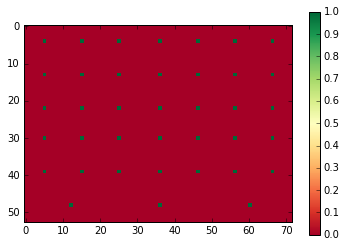

In [64]:
landmarks.plot_landmarks()

**COMMENT: I am guessing here (please, confirm):**
The following code highlights the 20-th landmark, and prints both the landmark id and the node id corresponding to the landmark (especially this last bit I am not sure of).

20
1650


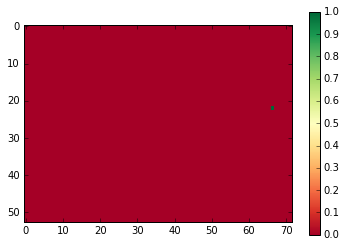

In [65]:
landmarks.plot_landmark(20)

## 6. Plot data & results

Plot qualities:

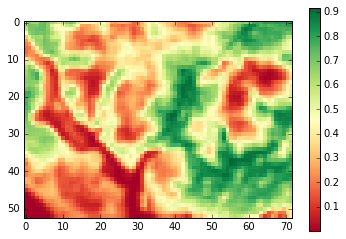

In [66]:
g.plot(l.qualities)

Plot in-degrees:

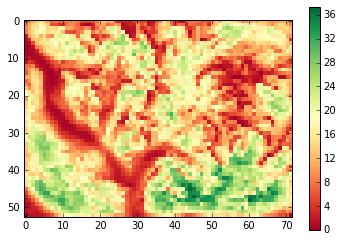

In [67]:
g.plot_indegrees()


Plot out-degrees:

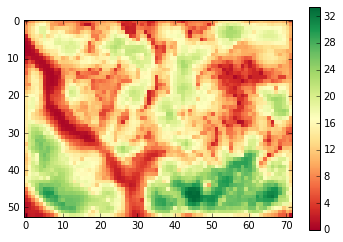

In [68]:
g.plot_outdegrees()

Plot the landmark affinities from a point (y, x).
**COMMENT: confirm my interpretation:**
The values shown are the affinities from the focal node to all other nodes through the different landmarks: the affinity from the source to the landmarks is multiplied (matrix) with the affinities from the landmarks to all nodes.

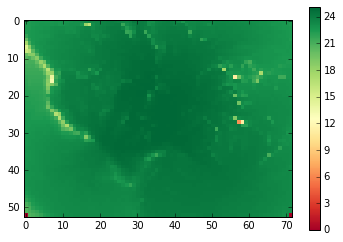

In [69]:
g.plot(landmarks.similarities_from(g.grid_coordinates_to_node_id([35, 5])))

**COMMENT: something must go wrong here** It really doesn't make sense that the following figure is identical to the previous one, as both are at the opposite side of the lake. How can this be?
Could the problem lie in the fact that the similarities are based on all landmarks. It gives the impression that the focal vector has no effect on the multiplication.

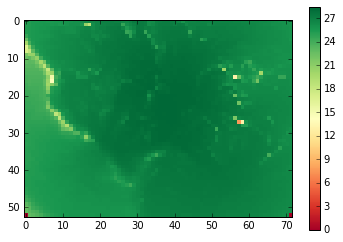

In [70]:
g.plot(landmarks.similarities_from(g.grid_coordinates_to_node_id([10, 45])))

**COMMENT: does this make sense?**
Comparing these focal vectors in the next plot, it gives the impression that they are as expected somewhat negatively correlated. Thus, the landmarks that are close for the one node are far for the other, which is what we would expect given their locations on the landscape. 

However, I had expected more extreme values. I guess the rather moderate values explains why the differences get washed out. Landmarks that have the highest "inbetweenness" between two nodes should contribute more than the marginal ones, whereas now it seems they contribute equally (not exactly, but my point is they should be punished more). 

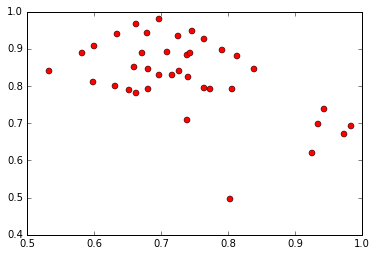

In [71]:
plt.plot(landmarks.similarities_all2L[g.grid_coordinates_to_node_id([35, 5]), :], 
         landmarks.similarities_all2L[g.grid_coordinates_to_node_id([10, 45]), :], 'ro')
plt.show()

Plot habitat functionalities of all points

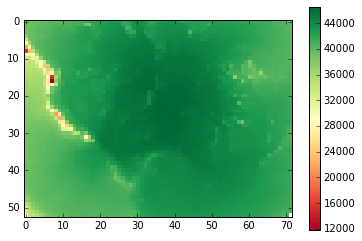

In [72]:
g.plot(landmarks.habitat_functionalities())

Plot harmonic centrality approximations of all points

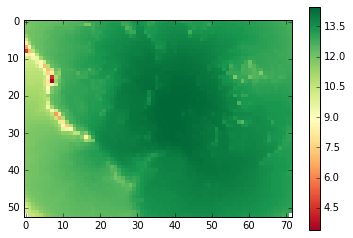

In [73]:
g.plot(landmarks.harmonic_approximation())

** COMMENT: Not idea what it does: some type of degree ("ad")**

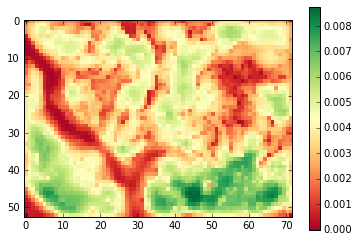

In [74]:
g.plot(g.A.mean(axis=1))

Let us investigate in a bit more detail one landmark at the time:

1
303


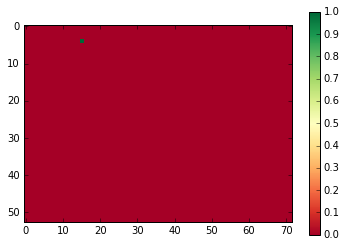

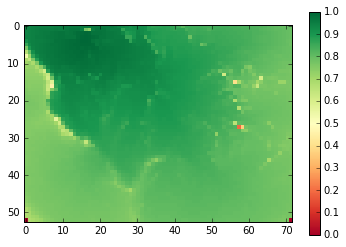

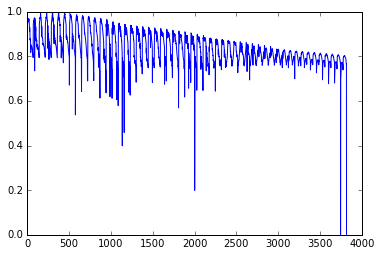

In [75]:
landmarks.plot_landmark(1)
landmarks.plot_landmark_similarities(1)
plt.figure()
plt.plot(landmarks.similarities_L2all[1, :])
plt.show()

37
3516


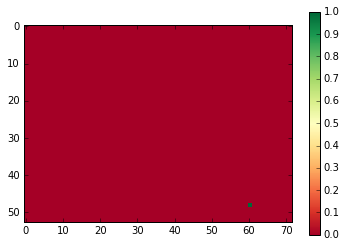

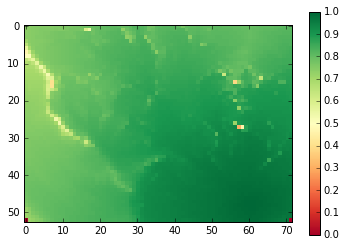

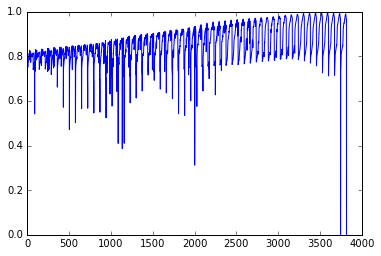

In [76]:
landmarks.plot_landmark(37)
landmarks.plot_landmark_similarities(37)
plt.figure()
plt.plot(landmarks.similarities_L2all[37, :])
plt.show()

7
941


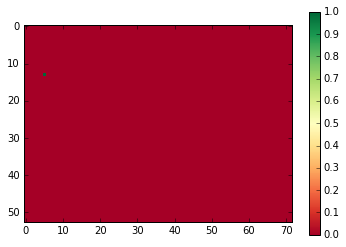

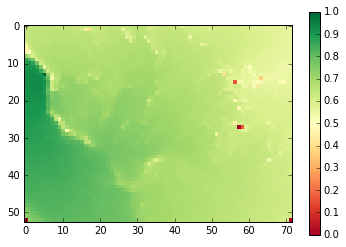

In [77]:
landmarks.plot_landmark(7)
landmarks.plot_landmark_similarities(7)
plt.figure()
#plt.plot(landmarks.similarities_L2all[7, :])
plt.show()

**COMMENT**
Here we observe the expected shaddow cast by major obstacles (notably the lake). 

** COMMENT: Not idea what the following bit does**

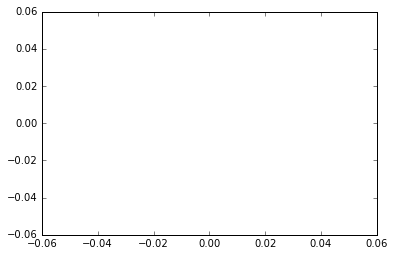

In [78]:
dist = landmarks.distances_L2all
landmark_centralities = dist.dot(np.ones((dist.shape[1],)))
plt.figure()
plt.plot(landmark_centralities)
plt.show()